# Life-Cycle Labor Supply of Couples with Children

Solves and simulates a $T$-period labor supply model with two-earner couples. <br>
**Motivated** by the study “Child-Related Transfers, Household Labor Supply and Welfare” by [Guner et al. (2020)](https://academic.oup.com/restud/article/87/5/2290/5809564). <br>
**Goal** is to replicate effects of child-related transfers.

For simplicity, couples cannot divorce nor save.

The **Bellman equation** and the recursive formulation of our simple model is 
$$
\begin{align*}
V_{t}(n_{t},K_{1,t},K_{2,t}) & =\max_{h_{1,t},h_{2,t}}U(c_{t},h_{1,t},h_{2,t},n_{t})\\
 & \qquad\qquad+\beta\mathbb{E}_{t}[V_{t+1}(n_{t+1},K_{1,t+1},K_{2,t+1})]\\
c_{t} & =\sum_{j=1}^{2}w_{j,t}h_{j,t}-T(w_{1,t}h_{1,t},w_{2,t}h_{2,t})\\
 & \qquad+\mathcal{C}(n_{t},h_{1,t},h_{2,t},w_{1,t},w_{2,t})\\
n_{t+1} & =\begin{cases}
\begin{array}{ll}
n_t + 1 & \text{with prob. } p(n_{t})\\
n_t & \text{with prob. } 1-p(n_{t})
\end{array}\end{cases}\\
\log w_{j,t} & =\alpha_{j,0}+\alpha_{j,1}K_{j,t},\;j\in\{1,2\}\\
K_{j,t+1} & =(1-\delta)K_{j,t}+h_{j,t},\;j\in\{1,2\}
\end{align*}
$$
where 
$$
p(n_t) = \begin{cases}
\begin{array}{ll}
p_n & \text{if } n_{t}=0\\
0 &  \text{if } n_{t}=1.
\end{array}\end{cases}
$$

**Child-related transfers:** We assume that if both work, they have to buy childcare. <br>
This means that conditional transfers are always a subsidy (cannot do 5 or 6 in taxonomy of Guner et al. (2020)). <br>
Child-related transfers are
$$
\begin{align*}
\mathcal{C}(n_{t},h_{1,t},h_{2,t},w_{1,t},w_{2,t}) & =\mathcal{C}_{1}(n_{t})+\mathcal{C}_{2}(n_{t},Y_{t})\\
 & +[\mathcal{C}_{3}(n_{t})+\mathcal{C}_{4}(n_{t},Y_{t})]\cdot\mathbf{1}(h_{1,t}\cdot h_{2,t}>0)
\end{align*}
$$
where household income is
$$
Y_{t}=\sum_{j=1}^{2}w_{j,t}h_{j,t}.
$$

The code could look something like
```python
def child_tran(self,hours1,hours2,income_hh,kids):
    par = self.par
    if kids<1:
        return 0.0
    
    else:
        C1 = par.uncon_uni                           #unconditional, universal transfer (>0)
        C2 = np.fmax(par.means_level - par.means_slope*income_hh , 0.0) #means-tested transfer (>0)
        # child-care related (net-of-subsidy costs)
        both_work = (hours1>0) * (hours2>0)
        C3 = par.cond*both_work                      #all working couples has this net cost (<0)
        C4 = par.cond_high*both_work*(income_hh>0.5) #low-income couples do not have this net-cost (<0)

    return C1+C2+C3+C4
```

**Preferences** are sum of individuals
$$
U(c_{t},h_{1,t},h_{2,t})=2\frac{(c_{t}/2)^{1+\eta}}{1+\eta}-\rho_{1}(n_{t})\frac{h_{1,t}^{1+\gamma}}{1+\gamma}-\rho_{2}(n_{t})\frac{h_{2,t}^{1+\gamma}}{1+\gamma}
$$
with 
$$
\rho_{j}(n_{t})=\rho_{0,j}+\rho_{1,j}n_{t}
$$

**Taxes** are on the household level and child-related transfers/costs are included in taxable income
$$
T(\tilde{Y})=(1-\lambda(\tilde{Y})^{-\tau})\cdot(\tilde{Y})
$$
where $\tilde{Y} = Y + \mathcal{C}(n_{t},h_{1,t},h_{2,t},w_{1,t},w_{2,t})$.

**Expected value** is
$$
\begin{align*}
\mathbb{E}_{t}[V_{t+1}(n_{t+1},K_{1,t+1},K_{2,t+1})] & =p(n_{t})V_{t+1}(n_{t}+1,K_{1,t+1},K_{2,t+1})\\
 & +(1-p(n_{t}))V_{t+1}(n_{t},K_{1,t+1},K_{2,t+1})
\end{align*}
$$

**Terminal period:** There are no bequests such that
$$
V_{T}(n_T,K_{1,T},K_{2,T})  =\max_{h_{1,T},h_{2,T}}U(c_{T},h_{1,T},h_{2,T})
$$

## Setup

In [64]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from DynHouseholdLaborModel import DynHouseholdLaborModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dual-Earner Model with Children

In [65]:
models = {}

In [66]:
# load local model file and initialize model class
# -> copy .py-module from last time and modify it!

models['Baseline'] = DynHouseholdLaborModelClass(par={'joint_tax':False})
models['Baseline'].solve()
models['Baseline'].simulate()

models['Joint tax'] = DynHouseholdLaborModelClass(par={'joint_tax':True})
models['Joint tax'].solve()
models['Joint tax'].simulate()

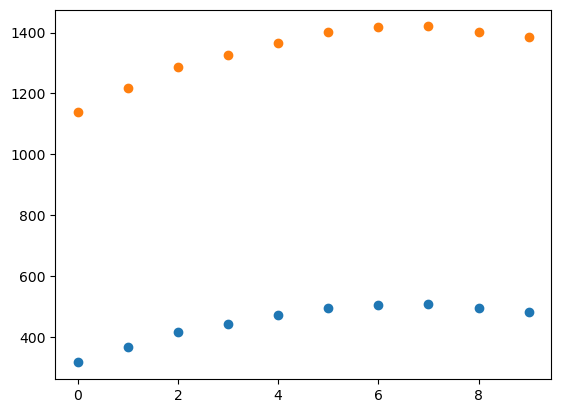

In [67]:
plt.scatter(np.arange(models['Baseline'].par.simT),np.mean(models['Baseline'].sim.tax_hh,axis=0),color='#1f77b4')
plt.scatter(np.arange(models['Baseline'].par.simT),np.mean(models['Joint tax'].sim.tax_hh,axis=0),color='#ff7f0e')

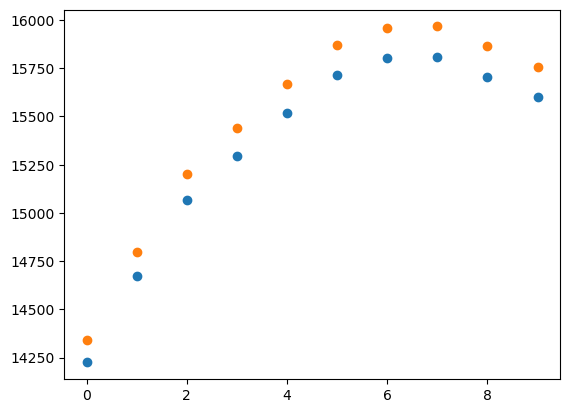

In [68]:
plt.scatter(np.arange(models['Baseline'].par.simT),np.mean(models['Baseline'].sim.income_hh,axis=0),color='#1f77b4')
plt.scatter(np.arange(models['Baseline'].par.simT),np.mean(models['Joint tax'].sim.income_hh,axis=0),color='#ff7f0e')

# Simulate child-related transfers reforms

In [69]:
models['Uncon-uni'] = DynHouseholdLaborModelClass(par={'joint_tax':True, 'uncon_uni':5000.0})
models['Uncon-uni'].solve()
models['Uncon-uni'].simulate()

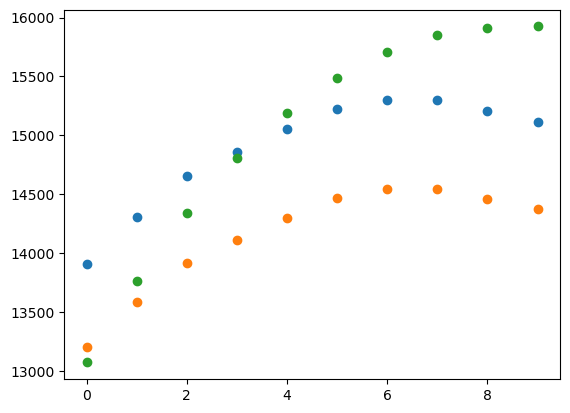

In [70]:
plt.scatter(np.arange(models['Baseline'].par.simT),np.mean(models['Baseline'].sim.c,axis=0))
plt.scatter(np.arange(models['Baseline'].par.simT),np.mean(models['Joint tax'].sim.c,axis=0))
plt.scatter(np.arange(models['Baseline'].par.simT),np.mean(models['Uncon-uni'].sim.c,axis=0))

In [ ]:
models['Uncon-uni'] = DynHouseholdLaborModelClass(par={'joint_tax':True, 'uncon_uni':5000.0, 'cond':2000.0})
models['Uncon-uni'].solve()
models['Uncon-uni'].simulate()